In [1]:
#Second part of figure 3. the weight changes

import torch
import sys
import os
import io
from os.path import exists
import numpy as np
import pickle
from scipy.special import softmax
import json
from scipy import stats
import gzip, pickle, pickletools
import warnings
import glob
import copy

from scipy.signal import butter,filtfilt


from sklearn.linear_model import LinearRegression
from scipy.stats import ranksums, wilcoxon
import statsmodels.api as sm


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.stats import ranksums, wilcoxon

from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot


from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.utils.utils import CPU_Unpickler,parse_configs, displ, memcheck, opsbase, mwa
from dynamics.analysis import state_analysis as sta
from dynamics.analysis import optim

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import interpolate
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib widget 
#out = widgets.Output(layout = widgets.Layout(height='300px'))

In [118]:
#save the lists?

savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'

with open(savedir+'weights_pop.dat','wb') as f:
    pickle.dump([[predlist_ofc_padded,predlist_str_padded,predlist_ofc_inp_padded,predlist_str_inp_padded, ],
                 [ predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl,predlist_str_inp_padded_nok_cl],
                [ predlist_ofc_padded_nok_nocl,predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl, predlist_str_padded_nok_nocl] ], f)

In [4]:
#save the lists?

savedir = '/Users/dhocker/projects/dynamics/results/20231003/figs/'

with open(savedir+'weights_pop.dat','rb') as f:
    [[predlist_ofc_padded,predlist_str_padded,predlist_ofc_inp_padded,predlist_str_inp_padded, ],
    [ predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl,predlist_str_inp_padded_nok_cl],
    [ predlist_ofc_padded_nok_nocl,predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl,
     predlist_str_padded_nok_nocl]] = pickle.load(f)
    


In [6]:
# time warp the prediction bit

# originally found median length of inference phase of task by counting files, but not possible here
# hard-coding the median value from original anlaysis 

#predlens = [len(glob.glob(datadir_dat(0)+str(num)+'/rnn_pred_'+str(num)+'*.model')) for num in range(1,51)]
#med_pred = np.floor(np.median(predlens)).astype(int)
#print(med_pred)
med_pred = 30


ps_idx = 10
pe_idx_old = ps_idx + 100

predmesh_new = np.linspace(0,1,med_pred)




predlist = [predlist_ofc_padded,predlist_str_padded,predlist_ofc_inp_padded,predlist_str_inp_padded, 
            predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl,predlist_str_inp_padded_nok_cl,
            predlist_ofc_padded_nok_nocl,predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl, predlist_str_padded_nok_nocl]

predlist_new = []

iter =0

for m in predlist:
    print(iter)
    preddat_m = copy.deepcopy(m)
    print(len(preddat_m))
    
    pred_m = []

    for k in range(len(preddat_m)):
        test = list(preddat_m[k])

        clip_idx_base = np.argwhere(np.isnan(test))
        clip_idx = clip_idx_base[0,0]
        j = 0
        while clip_idx <= ps_idx: # find first instance where it is greater than 
            clip_idx = clip_idx_base[j,0]
            j+=1

        #extract old pred section
        pred_old = test[ps_idx:clip_idx]
        predmesh_old = np.linspace(0,1,clip_idx-ps_idx)
        #interpolate
        pred_new = np.interp(predmesh_new,predmesh_old,pred_old)
        # cut oold data
        [test.pop(ps_idx) for j in range(100)]  #keep popping old data as it hits that index
        # insert new data
        [test.insert(ps_idx+k, pred_new[k]) for k in range(len(pred_new))]


        pred_m.append(np.array(test))
    predlist_new.append(pred_m)
    iter +=1


0
50
1
50
2
50
3
50
4
50
5
50
6
50
7
50
8
20
9
20
10
20
11
20


In [7]:
dowarp = True
if dowarp:
    predlist_ofc_padded = np.array(predlist_new[0])
    predlist_str_padded = np.array(predlist_new[1]) 
    predlist_ofc_inp_padded = np.array(predlist_new[2])
    predlist_str_inp_padded = np.array(predlist_new[3])
    predlist_ofc_padded_nok_cl = np.array(predlist_new[4])
    predlist_str_padded_nok_cl = np.array(predlist_new[5])
    predlist_ofc_inp_padded_nok_cl = np.array(predlist_new[6])
    predlist_str_inp_padded_nok_cl = np.array(predlist_new[7])
    predlist_ofc_padded_nok_nocl = np.array(predlist_new[8])
    predlist_str_inp_padded_nok_nocl = np.array(predlist_new[9])
    predlist_ofc_inp_padded_nok_nocl = np.array(predlist_new[10])
    predlist_str_padded_nok_nocl = np.array(predlist_new[11])

(120,)


/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_7601/698846121.py:18: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_str_padded, axis=0)


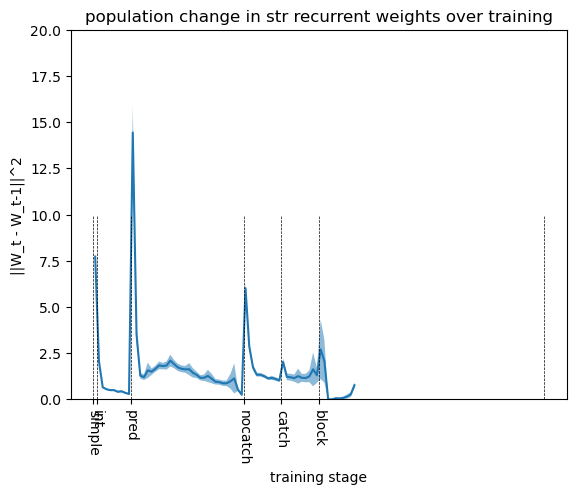

In [10]:


lmax = predlist_str_padded.shape[1]
lmax_nok_nocl = predlist_str_padded_nok_nocl.shape[1]
lmax_nok_cl = predlist_str_padded_nok_cl.shape[1]

#max samples for each stage. note how max number of samples from pred is 100? that matches the above constraint
if dowarp:
    nm = [0,1, 9, med_pred, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]
else:
    nm = [0,1, 9, 100, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]


clstart = sum(nm[0:2])
noclstart = sum(nm[0:3])


diffmean = np.nanmean(predlist_str_padded, axis=0)
print(diffmean.shape)
diffsem = np.nanstd(predlist_str_padded, axis=0)/np.sqrt(20)


plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)


#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)

plt.title('population change in str recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.ylim([0,20])

    

#plt.savefig(savedir+'str_weights_allcl_warped.pdf')
plt.show()

/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_7601/3641725327.py:1: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_ofc_padded, axis=0)


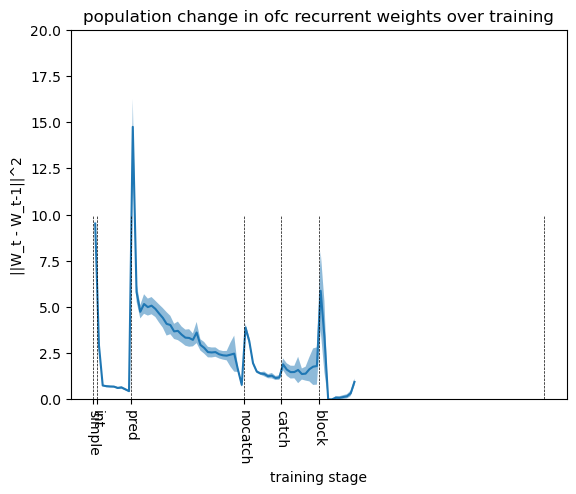

In [11]:
diffmean = np.nanmean(predlist_ofc_padded, axis=0)
diffsem = np.nanstd(predlist_ofc_padded, axis=0)/np.sqrt(20)



plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)


#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
#plt.title('population change in prediction head weights over training')
#plt.title('population change in memory head weights over training')
#plt.title('population change in ofc recurrent weights over training')
plt.title('population change in ofc recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
#plt.xlim([0,28])
plt.ylim([0,20])

    
#plt.savefig(savedir+'ofc_weights_allcl.pdf')
#plt.savefig(savedir+'ofc_weights_allcl_timewarped.pdf')
plt.show()